<a href="https://colab.research.google.com/github/fjt067316/Blackjack-RL/blob/main/Blackjack_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.7 MB/s eta 0:00:00


In [ ]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym

env = gym.make("Blackjack-v1", sab=True)

In [ ]:
done = False
observation, info = env.reset()

# observation = (16, 9, False)
# observation = (current_sum, dealer current face up card, do we have an ace?)

In [ ]:
action = env.action_space.sample()
action = 1

#observation, reward, terminated, truncated, info = env.step(action)

# observation=(24, 10, False)
# reward=-1.0
# terminated=True
# truncated=False
# info={}

# next_state: This is the observation that the agent will receive after taking the action.

# reward: This is the reward that the agent will receive after taking the action.

# terminated: This is a boolean variable that indicates whether or not the environment has terminated.

# truncated: This is a boolean variable that also indicates whether the episode ended by early truncation, i.e., a time limit is reached.

# info: This is a dictionary that might contain additional information about the environment.



In [ ]:
# Once terminated = True or truncated=True, we should stop the current episode and begin a new one with env.reset()

In [ ]:
# Basic Epsilon Greedy Model

class Agent:
  def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95 # discount past information
        ):

    self.q_values = defaultdict(lambda: np.zeros(env.action_space.n)) # indexed by observation ie past rewards for same state

    self.lr = learning_rate
    self.discount_factor = discount_factor

    self.epsilon = initial_epsilon
    self.epsilon_decay = epsilon_decay
    self.final_epsilon = final_epsilon

    self.training_error = []

  def get_action(self, obs: tuple[int, int, bool]) -> int:
    # take greddy action with probability 1-eps
    # np.random.random() is uniform dist over [0,1)

    if np.random.random() < self.epsilon:
      # explore
      return env.action_space.sample()
    else:
      return int(np.argmax(self.q_values[obs]))

  def update_rewards(self,
                    obs: tuple[int, int, bool],
                    action: int,
                    reward: float,
                    terminated: bool,
                    next_obs: tuple[int, int, bool] ):

    # terminated means we lost the round
    future_q_value = (not terminated) * np.max(self.q_values[next_obs]) # Bellman equation Q = Q + scale_factor * (future_reward_est - Q)

    # Temporal Difference is the difference between the current estimate of the Q-value for a state-action pair (self.q_values[obs][action]) and the updated estimate based on the observed reward and the estimated future Q-value.
    temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )
    # New Q-value=Current Q-value+Learning Rate*Temporal Difference
    self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference # update q values with reward
        )

    self.training_error.append(temporal_difference)

  def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)


In [ ]:
# hyperparameters
learning_rate = 0.001
n_episodes = 1_000_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = Agent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [ ]:
env.close() # pre

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

for episode in tqdm(range(n_episodes)): #tqdm is just a progress bar
  obs, info = env.reset() # reset on every terminated
  done = False

  # play one episode
  while(not done):
    action = agent.get_action(obs) # action_space: 0 = stay.  1 = hit.
    next_obs, reward, terminated, truncated, info = env.step(action)

    # update agent with new observation
    agent.update_rewards(obs, action, reward, terminated, next_obs)

    # update if the environment is done and the current obs
    done = terminated or truncated
    obs = next_obs
  agent.decay_epsilon()


100%|██████████| 1000000/1000000 [04:53<00:00, 3407.35it/s]


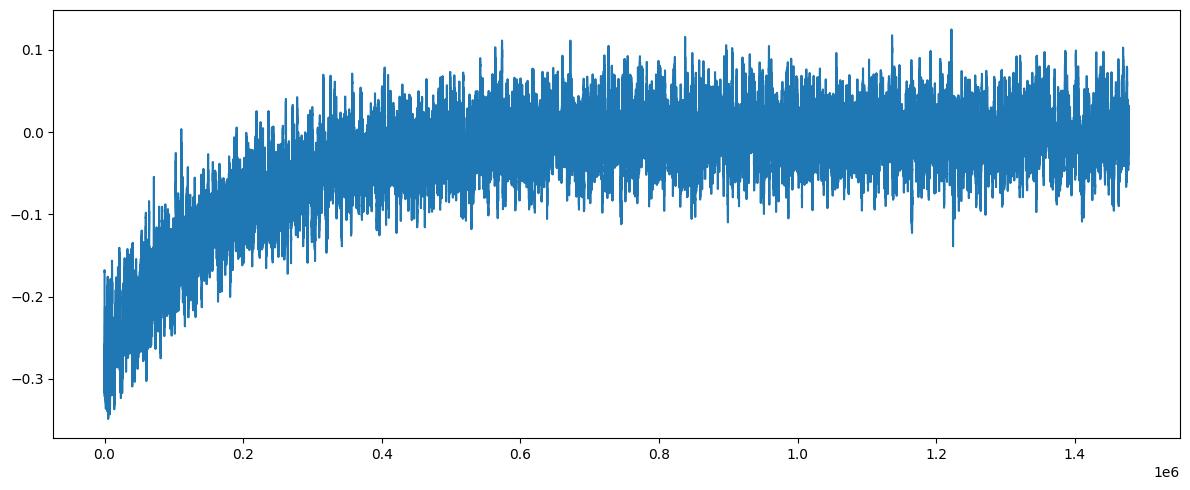

In [ ]:
fig, axs = plt.subplots(ncols=1, figsize=(12, 5))
rolling_length = 500

# take average over 500 width window
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)

axs.plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

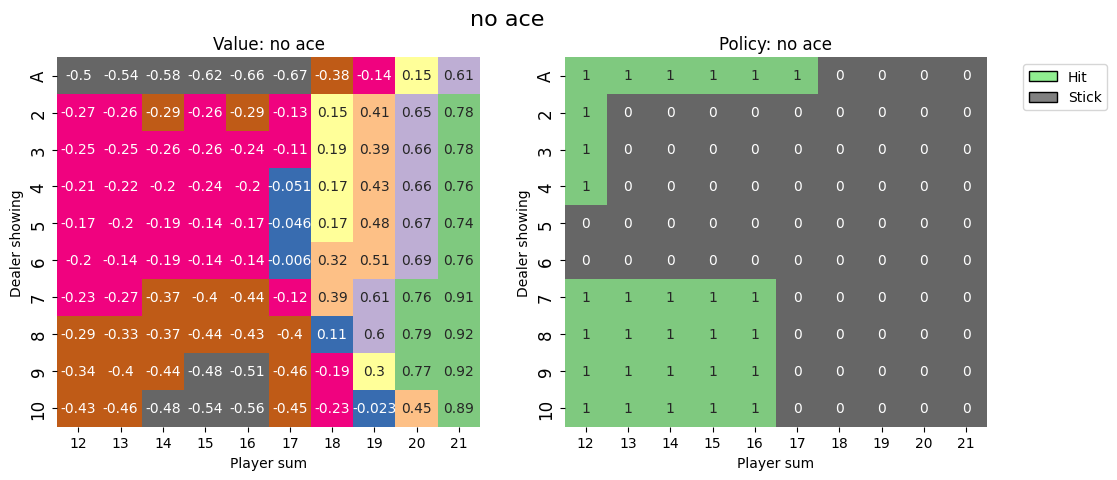

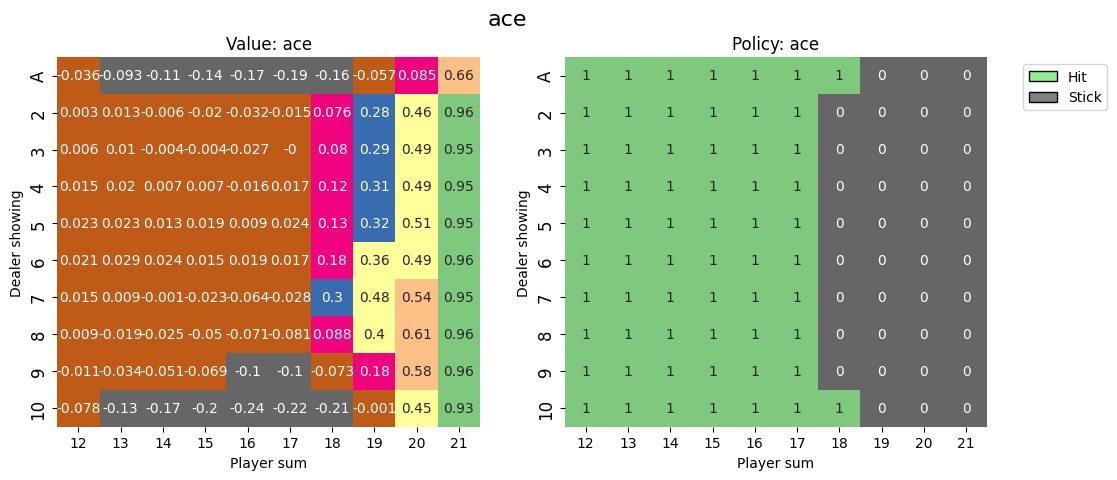

In [ ]:
def plot_policy(agen, usable_ace=False):
  # player_sum = [n for n in range(22)]

  reward_est = defaultdict(float)
  action = defaultdict(int)

  for obs, action_values in agent.q_values.items():
    # print(obs)  # current state ie our sum and dealer card
    # print(action_values) # idx 0 = reward for staying,  idx 1 = reward for hitting
    reward_est[obs] = float(np.max(action_values))
    action[obs] = int(np.argmax(action_values))

    # our_sum, dealer_card, ace = obs
  # print with and without ace states

  player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )
  # print(player_count)
  value = np.apply_along_axis(
        # lambda obs: str(round(reward_est[(obs[0], obs[1], usable_ace)], 3)) + " " + str(action[(obs[0], obs[1], usable_ace)]) ,
        lambda obs: round(reward_est[(obs[0], obs[1], usable_ace)], 3) ,
        axis=2,
        arr=np.dstack([player_count, dealer_count])
      )
  policy = np.apply_along_axis(
        # lambda obs: str(round(reward_est[(obs[0], obs[1], usable_ace)], 3)) + " " + str(action[(obs[0], obs[1], usable_ace)]) ,
        lambda obs: action[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count])
    )

  # value_grid = player_count, dealer_count, value
  # print(value_grid)
  # print(value)
  return value, policy

def create_plot(value_grid, policy_grid, title):

    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)
    # plot value grid
    fig.add_subplot(1, 2, 1)
    ax2 = sns.heatmap(value_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Value: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)
    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))

    return fig

value_grid, policy_grid = plot_policy(agent)
fig1 = create_plot(value_grid, policy_grid, "no ace")
value_grid, policy_grid = plot_policy(agent, True)
fig1 = create_plot(value_grid, policy_grid, "ace")
plt.show()

In [ ]:
env.close()